In [70]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM, Dropout, Bidirectional
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [71]:
df = pd.read_csv('AAPL.csv')
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600
5,1980-12-19,0.126116,0.126674,0.126116,0.126116,0.098578,48630400
6,1980-12-22,0.132254,0.132813,0.132254,0.132254,0.103376,37363200
7,1980-12-23,0.137835,0.138393,0.137835,0.137835,0.107739,46950400
8,1980-12-24,0.145089,0.145647,0.145089,0.145089,0.113409,48003200
9,1980-12-26,0.158482,0.159040,0.158482,0.158482,0.123877,55574400


In [72]:
target_columns = ['Date', 'Close']
df = df[target_columns]
df.head()

,Date,Close
0,1980-12-12,0.128348
1,1980-12-15,0.121652
2,1980-12-16,0.112723
3,1980-12-17,0.115513
4,1980-12-18,0.118862


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10409 entries, 0 to 10408
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    10409 non-null  object 
 1   Close   10409 non-null  float64
dtypes: float64(1), object(1)
memory usage: 162.8+ KB


In [74]:
data_train, data_test = train_test_split(df, test_size=0.2, random_state=69, shuffle=False)

In [75]:
dates = data_train['Date'].values
stock = data_train['Close'].values
dates_test = data_test['Date'].values
stock_test = data_test['Close'].values

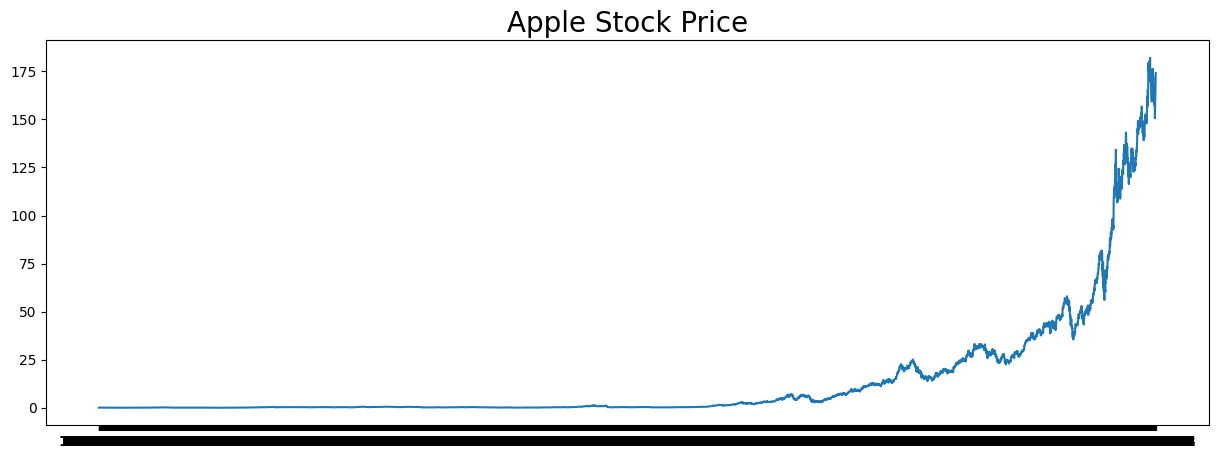

In [76]:
plt.figure(figsize=(15,5))
plt.plot(df['Date'],df['Close'])
plt.title('Apple Stock Price', fontsize=20)
plt.show()

In [77]:
min_max_scaler = MinMaxScaler()
stock = stock.reshape(-1,1)
stock_test = stock_test.reshape(-1,1)
min_max_scaler.fit(stock)

stock = min_max_scaler.transform(stock)
stock_test = min_max_scaler.transform(stock_test)

print(stock.shape)

(8327, 1)


In [78]:
threshold_mae = (stock.max() - stock.min()) * 10/100
print(threshold_mae) #mae model harus lebih kecil dari ini

0.09999999999999998


In [79]:
class BerhentiBos(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('mae')<threshold_mae and logs.get('val_mae')<threshold_mae:
      self.model.stop_training = True

In [80]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size+1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

In [97]:
train_set = windowed_dataset(stock, window_size=50, batch_size=100,shuffle_buffer=1000)
test_set = windowed_dataset(stock_test, window_size=50, batch_size=100, shuffle_buffer=1000)
model = tf.keras.Sequential([
    Bidirectional(LSTM(32, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(16, activation="relu"),
    Dense(1)
])

In [98]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.Huber(),
    metrics=['mae']
)

In [99]:
berhenti_bos = BerhentiBos()
mymodel = model.fit(
    train_set,
    epochs=100,
    validation_data=test_set,
    callbacks=[berhenti_bos],
    verbose=2
)

Epoch 1/100
83/83 - 11s - loss: 0.0090 - mae: 0.0576 - val_loss: 1.1825 - val_mae: 1.6255 - 11s/epoch - 136ms/step
Epoch 2/100
83/83 - 3s - loss: 0.0036 - mae: 0.0608 - val_loss: 0.8722 - val_mae: 1.1901 - 3s/epoch - 35ms/step
Epoch 3/100
83/83 - 2s - loss: 0.0017 - mae: 0.0298 - val_loss: 0.8829 - val_mae: 1.2200 - 2s/epoch - 25ms/step
Epoch 4/100
83/83 - 2s - loss: 0.0015 - mae: 0.0251 - val_loss: 0.8283 - val_mae: 1.1274 - 2s/epoch - 25ms/step
Epoch 5/100
83/83 - 2s - loss: 0.0012 - mae: 0.0228 - val_loss: 0.8448 - val_mae: 1.1650 - 2s/epoch - 25ms/step
Epoch 6/100
83/83 - 2s - loss: 0.0012 - mae: 0.0219 - val_loss: 0.8137 - val_mae: 1.1168 - 2s/epoch - 29ms/step
Epoch 7/100
83/83 - 3s - loss: 0.0011 - mae: 0.0208 - val_loss: 0.7841 - val_mae: 1.0688 - 3s/epoch - 35ms/step
Epoch 8/100
83/83 - 2s - loss: 9.7100e-04 - mae: 0.0197 - val_loss: 0.7724 - val_mae: 1.0528 - 2s/epoch - 25ms/step
Epoch 9/100
83/83 - 2s - loss: 8.6974e-04 - mae: 0.0188 - val_loss: 0.7671 - val_mae: 1.0477 - 2s

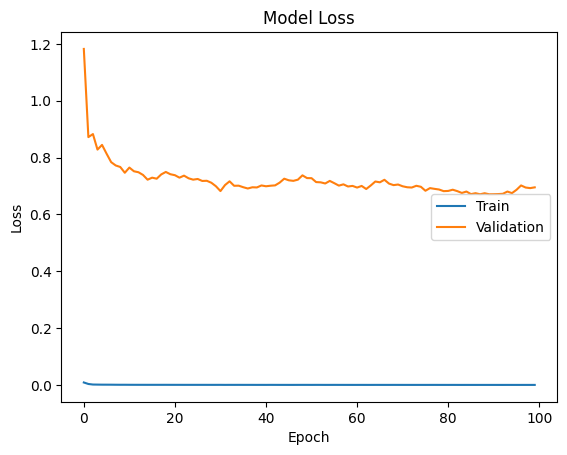

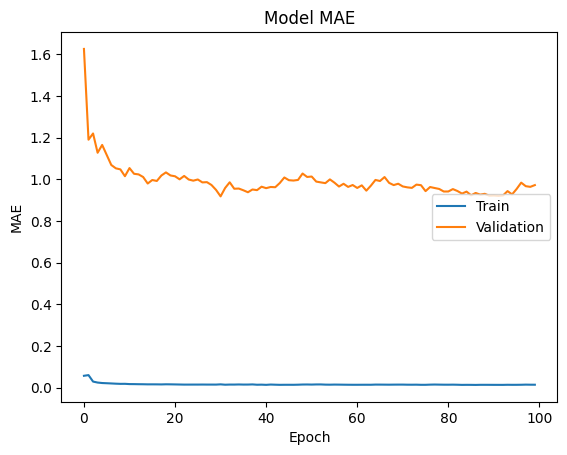

In [100]:
plt.plot(mymodel.history['loss'])
plt.plot(mymodel.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

plt.plot(mymodel.history['mae'])
plt.plot(mymodel.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='center right')
plt.show()

In [101]:
prediction_train = model.predict(train_set)

83/83 [==============================] - 3s 15ms/step


In [102]:
stock = min_max_scaler.inverse_transform(stock.reshape(-1, 1))
prediction_train = min_max_scaler.inverse_transform(prediction_train.reshape(-1, 1))

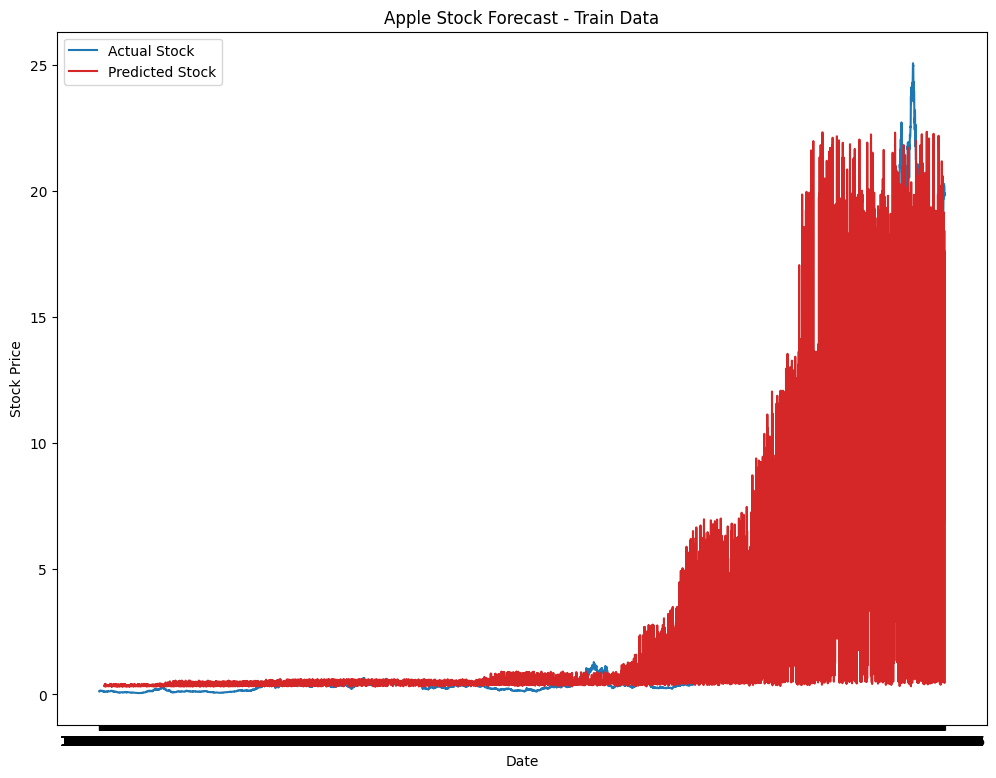

In [104]:
plt.figure(figsize=(12,9))
plt.plot(dates, stock, label="Actual Stock")
plt.plot(dates[50:], prediction_train, label="Predicted Stock", color="C3")
plt.legend()
plt.title("Apple Stock Forecast - Train Data")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()

In [105]:
prediction_test = model.predict(test_set)

21/21 [==============================] - 0s 11ms/step


In [106]:
stock_test = min_max_scaler.inverse_transform(stock_test.reshape(-1, 1))
prediction_test = min_max_scaler.inverse_transform(prediction_test.reshape(-1, 1))

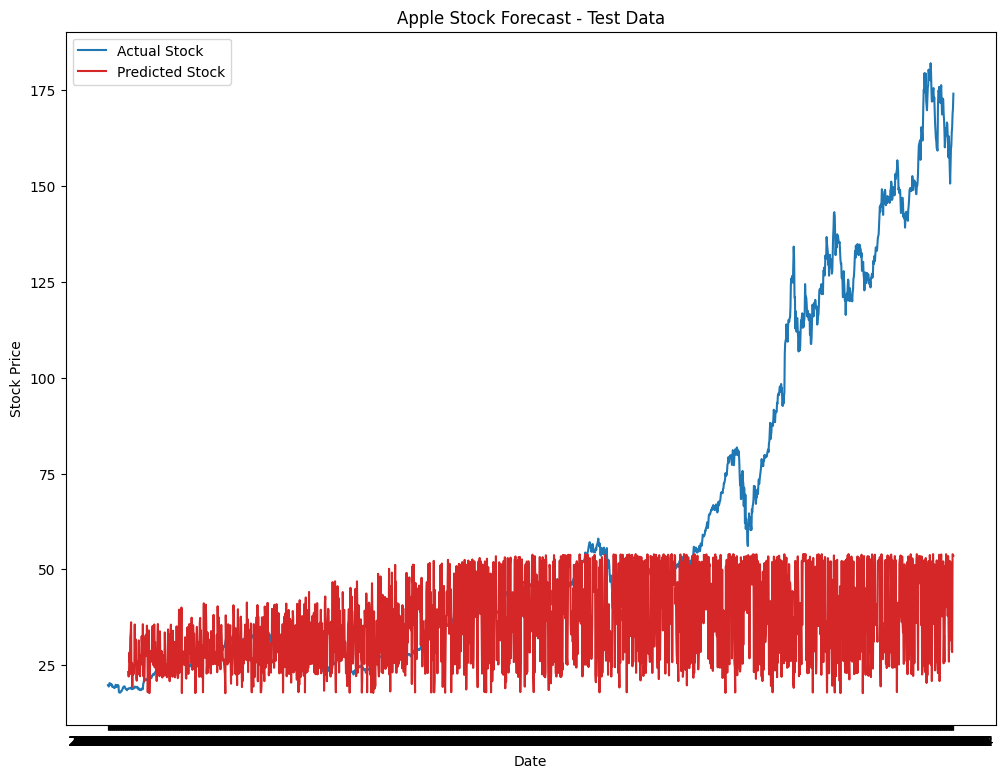

In [108]:
plt.figure(figsize=(12,9))
plt.plot(dates_test, stock_test, label="Actual Stock")
plt.plot(dates_test[50:], prediction_test, label="Predicted Stock", color="C3")
plt.legend()
plt.title("Apple Stock Forecast - Test Data")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()